# Quickdraw Classification

--> Ce notebook consiste en une tâche de classification d'images 28x28:
- 10 classes au total provenant du [site](https://quickdraw.withgoogle.com/data) Quickdraw.

## Création du jeu de données

### Chargement des données 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

- Initialisation

In [3]:
DATA_PATH = '/content/drive/MyDrive/HollowOak/QuickDraw/DATA/'
filenames = os.listdir(DATA_PATH)

In [4]:
# Initialisation..
class_size = 8000
class_names = []
size = 10 * class_size

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

- Lecture des données

In [5]:
temp = 0
class_id = 0
for name in filenames:
  # Charge la quantité désirée pour la classe courante
  class_names.append(name.replace('full_numpy_bitmap_', '').replace('.npy', ''))
  draws = np.load(os.path.join(DATA_PATH, name))
  draws = draws[:class_size]
  # Mise à jour de 'images' et 'targets'
  images[temp : temp+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
  targets[temp : temp+draws.shape[0]] = class_id
  temp += draws.shape[0]
  class_id += 1
images = images.astype(np.float32)

- Mélange et répartition des données 

In [6]:
# Mélange des données
np.random.seed(42)
indices = np.arange(size)
np.random.shuffle(indices)
images = images[indices]
targets = targets[indices]

images, valid_images, targets, valid_targets = train_test_split(images, targets, test_size=0.25)

print('Shape images_set:', images.shape, targets.shape)
print('Shape valid_set:', valid_images.shape, valid_targets.shape)
print(class_names)

Shape images_set: (60000, 28, 28) (60000,)
Shape valid_set: (20000, 28, 28) (20000,)
['sword', 'television', 'wheel', 'scissors', 'flower', 'fish', 'spider', 'palm tree', 'pants', 'guitar']


### Visualiation de quelques données

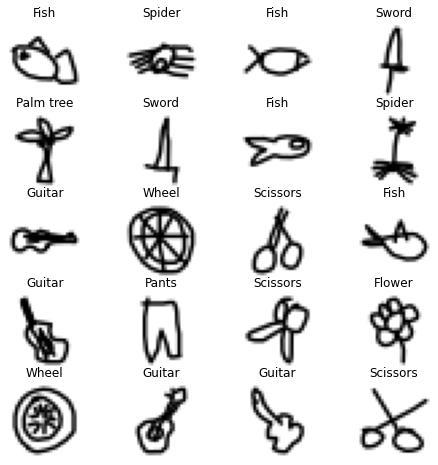

In [7]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
  np.random.seed(i)
  index = np.random.randint(len(images))
  img = images[index]
  fig.add_subplot(rows, columns, i)
  plt.title(class_names[int(targets[index])].capitalize())
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

### Normalisation

In [8]:
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_valid_images = scaler.transform(valid_images.reshape(-1, 28*28))

# Reshape pour le format tensorflow
scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_valid_images = scaled_valid_images.reshape(-1, 28, 28, 1)

### Finalisation 

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_valid_images, valid_targets))

In [10]:
# Vérification shape..
for item in train_dataset:
  print(item[0].shape, item[1].shape)
  break

(28, 28, 1) ()


## Conception du model

In [11]:
class ConvModel(tf.keras.Model):
  
  def __init__(self):
    super(ConvModel, self).__init__()
    # Couches de convolutions
    self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name='conv1')
    self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name='conv2')
    self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name='conv3')
    # Flatten
    self.flatten = tf.keras.layers.Flatten(name='flatten')
    # Couches denses
    self.d1 = tf.keras.layers.Dense(128, activation='relu', name='d1')
    self.out = tf.keras.layers.Dense(10, activation='softmax', name='output')

  def call(self, image):
    conv1 = self.conv1(image)
    conv2= self.conv2(conv1)
    conv3 = self.conv3(conv2)
    flatten = self.flatten(conv3)
    d1 = self.d1(flatten)
    output = self.out(d1)
    return output

In [12]:
model = ConvModel()

### Pertes, métriques et optimiseurs

In [13]:
loss_SCC = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [14]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

### Fonctions d'entrainement

In [15]:
@tf.function
def train_step(image, targets):
  with tf.GradientTape() as tape:
    predictions = model(image)
    loss = loss_SCC(targets, predictions)
  # Calcul des gradients
  gradients = tape.gradient(loss, model.trainable_variables)
  # Mise à jour des poids
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Mise à jour perte/métrique
  train_loss(loss)
  train_accuracy(targets, predictions)

In [16]:
@tf.function
def valid_step(image, targets):
  predictions = model(image)
  v_loss = loss_SCC(targets, predictions)
  # Mise à jour perte/métrique
  valid_loss(v_loss)
  valid_accuracy(targets, predictions)

## Entrainement et évaluation du model

In [17]:
epoch = 10
batch_size = 32
template = '\r Batch {}/{}       Train Loss: {:.17f}         Train accuracy: {}'
template_v = '\r Epoch: {}                Valid loss: {:.17f}         Valid accuracy: {}'
# Fonction destinée à l'affichage au cours de l'entrainement
scale_value = lambda x: x if x<=len(targets) else len(targets)  

for epoch in range(epoch):
  b = batch_size

  # Training set
  for images_batch, targets_batch in train_dataset.batch(batch_size):
    train_step(images_batch, targets_batch)
    print(template.format(
        b, len(targets), train_loss.result(), train_accuracy.result()*100
    ), end='')
    b = scale_value(b+batch_size)

  print('\n', end='')

  # Validation set
  for images_batch, targets_batch in valid_dataset.batch(batch_size):
    valid_step(images_batch, targets_batch)
    print(template_v.format(
        epoch+1, valid_loss.result(), valid_accuracy.result()*100
    ), end='')
  print('\n')
  
  # Reset à la fin de chaque époque
  valid_loss.reset_states()
  valid_accuracy.reset_states()
  train_loss.reset_states()
  train_accuracy.reset_states()

 Batch 60000/60000       Train Loss: 0.34861561655998230         Train accuracy: 89.49833679199219
 Epoch: 1                Valid loss: 0.23684372007846832         Valid accuracy: 93.0250015258789

 Batch 60000/60000       Train Loss: 0.16026459634304047         Train accuracy: 95.1883316040039
 Epoch: 2                Valid loss: 0.27817276120185852         Valid accuracy: 92.6199951171875

 Batch 60000/60000       Train Loss: 0.08043134957551956         Train accuracy: 97.37999725341797
 Epoch: 3                Valid loss: 0.34848397970199585         Valid accuracy: 92.55500030517578

 Batch 60000/60000       Train Loss: 0.05068977549672127         Train accuracy: 98.27999877929688
 Epoch: 4                Valid loss: 0.37206649780273438         Valid accuracy: 93.28500366210938

 Batch 60000/60000       Train Loss: 0.03729684650897980         Train accuracy: 98.82833099365234
 Epoch: 5                Valid loss: 0.41202747821807861         Valid accuracy: 92.74500274658203

 Batch 6